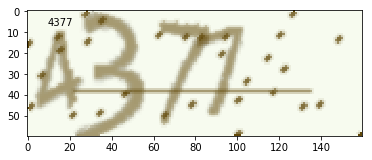

In [30]:
import numpy as np
import tensorflow as tf
from captcha.image import ImageCaptcha  #导入生成验证码的库
import matplotlib.pyplot as plt
from PIL import Image
import random

#验证码在这三个list里面随机选择
number=['0','1','2','3','4','5','6','7','8','9']
#alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']  
#ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'] 


#第一个参数是验证码的获选集,第二个是验证码有多少个条数
def random_captcha_text(char_set=number,captcha_size=4):
    captcha_text=[]
    for i in range(captcha_size):
        c=random.choice(char_set)
        captcha_text.append(c)
    return captcha_text

def gen_captcha_text_and_image():
    image=ImageCaptcha()
    
    #把List转换为字符串
    captcha_text=random_captcha_text()
    captcha_text=''.join(captcha_text)
   
    #把字符型的传进去它就会帮我们生成图像验证码
    captcha=image.generate(captcha_text)
    
    captcha_image=Image.open(captcha)
    
    #把验证码保存为numpy.array的格式
    captcha_image=np.array(captcha_image)
    #返回labels和图片
    return captcha_text,captcha_image
if __name__=='__main__':
    text,image=gen_captcha_text_and_image()
    f=plt.figure()
    ax=f.add_subplot(111)
    ax.text(0.1,0.9,text,ha='center',va='center',transform=ax.transAxes)
    plt.imshow(image)
    plt.show()

In [44]:
def convert2gray(img):
    if(len(img.shape)>2):
        #将图片转化为灰度图
        gray=np.mean(img,-1)
        # 上面的转法较快，正规转法如下  
        # r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]  
        # gray = 0.2989 * r + 0.5870 * g + 0.1140 * b 
        return gray
    else:
        return img
def text2vec(text):
    text_len=len(text)
    if(text_len>MAX_CAPTCHA):
        raise ValueError('验证码最长4个字符')
    #初始化一个向量
    vector=np.zeros(MAX_CAPTCHA*CHAR_SET_LEN)
    
    def char2pos(c):  
        if c =='_':  
            k = 62  
            return k  
        k = ord(c)-48  
        if k > 9:  
            k = ord(c) - 55  
            if k > 35:  
                k = ord(c) - 61  
                if k > 61:  
                    raise ValueError('No Map')   
        return k  
    for i, c in enumerate(text):  
        idx = i * CHAR_SET_LEN + char2pos(c)  
        vector[idx] = 1  
    return vector  

# 向量转回文本  
def vec2text(vec):  
    char_pos = vec.nonzero()[0]  
    text=[]  
    for i, c in enumerate(char_pos):  
        char_at_pos = i #c/63  
        char_idx = c % CHAR_SET_LEN  
        if char_idx < 10:  
            char_code = char_idx + ord('0')  
        elif char_idx <36:  
            char_code = char_idx - 10 + ord('A')  
        elif char_idx < 62:  
            char_code = char_idx-  36 + ord('a')  
        elif char_idx == 62:  
            char_code = ord('_')  
        else:  
            raise ValueError('error')  
        text.append(chr(char_code))  
    return "".join(text)  


def get_next_batch(batch_size=128):
    batch_x=np.zeros([batch_size,IMAGE_HEIGHT*IMAGE_WIDTH])
    batch_y=np.zeros([batch_size,MAX_CAPTCHA*CHAR_SET_LEN])
    
    def warp_gen_captcha_text_and_image():
        while(True):
            text,image=gen_captcha_text_and_image()
            if(image.shape==(60,160,3)):
                return text,image
    for i in range(batch_size):
        text,image=warp_gen_captcha_text_and_image()
        image=convert2gray(image)
        batch_x[i,:]=image.flatten()/255
        batch_y[i,:]=text2vec(text)
    return batch_x,batch_y
        
    
    
def crack_captcha_cnn():
    #第一维是batch_size长度，最后一个代表着图像的通道
    x=tf.reshape(X,shape=[-1,IMAGE_HEIGHT,IMAGE_WIDTH,1])
    
    #三层卷积神经网络
    w_c1=tf.Variable(tf.truncated_normal([3,3,1,32]))
    b_c1=tf.Variable(tf.truncated_normal([32]))
    conv1=tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x,w_c1,strides=[1,1,1,1],padding='SAME'),b_c1))
    conv1=tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    conv1=tf.nn.dropout(conv1,keep_prob)
    
    w_c2=tf.Variable(tf.truncated_normal([3,3,32,64]))
    b_c2=tf.Variable(tf.truncated_normal([64]))
    conv2=tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv1,w_c2,strides=[1,1,1,1],padding='SAME'),b_c2))
    conv2=tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    conv2=tf.nn.dropout(conv2,keep_prob)
    
    w_c3=tf.Variable(tf.truncated_normal([3,3,64,128]))
    b_c3=tf.Variable(tf.truncated_normal([128]))
    conv3=tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv2,w_c3,strides=[1,1,1,1],padding='SAME'),b_c3))
    conv3=tf.nn.max_pool(conv3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    conv3=tf.nn.dropout(conv3,keep_prob)
    
    #全连接层
    w_d=tf.Variable(tf.truncated_normal([8*20*128,1024]))
    b_d=tf.Variable(tf.truncated_normal([1024]))
    dense=tf.reshape(conv3,[-1,w_d.get_shape().as_list()[0]])
    dense=tf.nn.relu(tf.add(tf.matmul(dense,w_d),b_d))
    dense=tf.nn.dropout(dense,keep_prob)
    
    w_out=tf.Variable(tf.truncated_normal([1024,MAX_CAPTCHA*CHAR_SET_LEN]))
    b_out=tf.Variable(tf.truncated_normal([MAX_CAPTCHA*CHAR_SET_LEN]))
    out=tf.add(tf.matmul(dense,w_out),b_out)
    return out

def train_crack_captcha_cnn():
    output=crack_captcha_cnn()     #卷积神经网络的架构
    loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output,labels=Y))
     # 最后一层用来分类的softmax和sigmoid有什么不同？  
    # optimizer 为了加快训练 learning_rate应该开始大，然后慢慢衰 
    optm=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    pred=tf.reshape(output,[-1,MAX_CAPTCHA,CHAR_SET_LEN])
    max_idx_p=tf.argmax(pred,2)
    max_idx_1=tf.argmax(tf.reshape(Y,[-1,MAX_CAPTCHA,CHAR_SET_LEN]),2)
    correct_pred=tf.equal(max_idx_p,max_idx_1)
    accuracy=tf.reduce_mean(tf.cast(correct_pred,tf.float32))
    saver=tf.train.Saver()
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        step=0
        while(True):
            batch_x,batch_y=get_next_batch(64)
            _,losses=sess.run([optm,loss],feed_dict={X:batch_x,Y:batch_y,keep_prob:0.9})
            print(step,losses)
            if(step%10==0):
                
                batch_x_test,batch_y_test=get_next_batch(100)
                acc = sess.run(accuracy, feed_dict={X: batch_x_test, Y: batch_y_test, keep_prob: 1.})  
                print(step, acc)  
                # 如果准确率大于50%,保存模型,完成训练  
                if acc > 0.50:  
                    saver.save(sess, "F://hua//mo//crack_capcha.model", global_step=step)  
                    break  
            step+=1

In [ ]:
if __name__=='__main__':
    number=['0','1','2','3','4','5','6','7','8','9']
    text,image=gen_captcha_text_and_image()
    print("验证码图像channel:",image.shape)#验证码图像channel: (60, 160, 3)
    
    #定义神经网络的参数
    IMAGE_HEIGHT=60
    IMAGE_WIDTH=160
    MAX_CAPTCHA=len(text)
    print("验证码最长字符数：",MAX_CAPTCHA)  #4
    
    char_set=number
    CHAR_SET_LEN=len(char_set)
    
    #彩色图转换为灰度图，因为色彩对我们验证码识别起不了多大的作用
    X=tf.placeholder(tf.float32,shape=[None,IMAGE_HEIGHT*IMAGE_WIDTH],name='X_input')
    Y=tf.placeholder(tf.float32,shape=[None,MAX_CAPTCHA*CHAR_SET_LEN])
    keep_prob=tf.placeholder(tf.float32)
    train_crack_captcha_cnn()

验证码图像channel: (60, 160, 3)
验证码最长字符数： 4
0 782316.0
0 0.1175
1 476365.0
2 267516.0
3 182434.0
4 164142.0
5 165034.0
6 177456.0
7 182801.0
8 199731.0
9 189876.0
10 192637.0
10 0.0875
11 181773.0
12 177820.0
13 178231.0
14 157886.0
15 165493.0
16 165702.0
17 150188.0
18 150885.0
19 147106.0
20 141974.0
20 0.1125
21 132414.0
22 127354.0
23 123429.0
24 115762.0
25 107850.0
26 102700.0
27 110030.0
28 101843.0
29 99596.3
30 103374.0
30 0.105
31 93179.2
32 95146.0
33 93175.7
34 94045.8
35 87561.0
36 86297.6
37 83960.7
38 82582.2
39 80777.7
40 75993.5
40 0.0775
41 79573.3
42 75512.7
43 74700.6
44 72182.7
45 73679.3
46 73264.8
47 71733.3
48 67582.7
49 69926.3
50 63463.2
50 0.105
51 66906.8
52 68211.7
53 61092.3
54 63838.6
55 62613.3
56 59516.9
57 61659.7
58 59933.5
59 56344.4
60 61344.4
60 0.0925
61 61154.0
62 57443.7
63 50601.0
64 50473.8
65 54840.5
66 54066.1
67 54170.9
68 48018.0
69 52064.4
70 50972.3
70 0.1025
71 52619.3
72 46202.1
73 49255.4
74 50617.9
